In [18]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
from src.models import TemporalPC, MultilayertPC
from src.utils import *
from src.get_data import *

In [19]:
tone_led = [[1,3], [2,4]]
led_reward = [[3,5], [4,0]]

In [20]:
# sequences
num_cues = 4
# seq = random.randint(0,4)*[0]
# for _ in range(num_cues):
#     seq += random.randint(1,2)*[0] + random.choice(tone_led) 

seq = [1,2,3,2,1,2,3,2,1,2,3]
inputs = nn.functional.one_hot(torch.tensor(seq), num_classes= num_cues)

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

result_path = os.path.join('./results/', 'moving_bar')
if not os.path.exists(result_path):
    os.makedirs(result_path)

seq_len = inputs.size()[0]
h, w = 5, 5
inf_iters = 5 # for this experiment inf iters too large is harmful
inf_lr = 5e-3
learn_iters = 1500
learn_lr = 1e-2
latent_size = num_cues
control_size = num_cues
flattened_size = num_cues
sparse_penal = 0
n_cued = 1 # number of cued images
assert(n_cued < seq_len)

xs = inputs.to(device)
us = torch.zeros((seq_len, control_size)).to(device)

torch.manual_seed(1)
model = TemporalPC(control_size, latent_size, flattened_size, nonlin='linear').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learn_lr)

cpu


In [22]:
train_losses = []
for learn_iter in range(learn_iters):
    loss = 0
    # prev_z = model.init_hidden(1).to(device)
    prev_z = torch.zeros((1, latent_size)).to(device)
    for k in range(seq_len):
        x, u = xs[k,:], us[k,:]
        optimizer.zero_grad()
        model.inference(inf_iters, inf_lr, x, u, prev_z)
        energy = model.update_grads(x, u, prev_z)
        energy.backward()
        optimizer.step()
        prev_z = model.z.clone().detach()
        loss += energy.item() / seq_len
    train_losses.append(loss)
    if learn_iter%50 == 0:
        print(f'Iteration {learn_iter+1}, loss {loss}')

Iteration 1, loss 0.9837772737849841
Iteration 51, loss 0.35543840918266634
Iteration 101, loss 0.11135450187562541
Iteration 151, loss 0.07255655275234445
Iteration 201, loss 0.05035283147696067
Iteration 251, loss 0.027989443357166074
Iteration 301, loss 0.012477326487979471
Iteration 351, loss 0.0059208618850706525
Iteration 401, loss 0.0040196247176605875
Iteration 451, loss 0.0035235688847024
Iteration 501, loss 0.003310069886290214
Iteration 551, loss 0.003115160023629538
Iteration 601, loss 0.002899273939626503
Iteration 651, loss 0.002666550083879635
Iteration 701, loss 0.0024255045751818793
Iteration 751, loss 0.0021834248655068222
Iteration 801, loss 0.0019463933131191882
Iteration 851, loss 0.0017191700399879749
Iteration 901, loss 0.00150516549712682
Iteration 951, loss 0.0013065266684861854
Iteration 1001, loss 0.0011245637117760702
Iteration 1051, loss 0.0009603015623724785
Iteration 1101, loss 0.0008144753208563833
Iteration 1151, loss 0.0006880686126929835
Iteration 120

In [23]:
# retrieval
# prev_z = model.init_hidden(1).to(device)
prev_z = torch.zeros((1, latent_size)).to(device)
# collect the cues
cue = torch.zeros((seq_len, flattened_size))
# collect the retrievals
recall = torch.zeros((seq_len, flattened_size))

inf_iters = 2000
hiddens = []
for k in range(seq_len-2):
    x, u = xs[k+2, :], us[k+2, :] # [batch_size, 784]
    if k + 1 <= n_cued:
        model.inference(inf_iters, inf_lr, x, u, prev_z)
        prev_z = model.z.clone().detach()
        recall[k, :] = x.clone().detach()
        cue[k, :] = x.clone().detach()
    else:
        prev_z, pred_x = model(u, prev_z)
        recall[k, :] = pred_x
        cue[k, :] = torch.zeros_like(pred_x)
    hiddens.append(prev_z.clone().detach())


In [24]:
cue

tensor([[0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [32]:
torch.argmax(recall, axis=1)


tensor([3, 3, 1, 1, 3, 3, 1, 1, 3, 0, 0])

<StemContainer object of 3 artists>

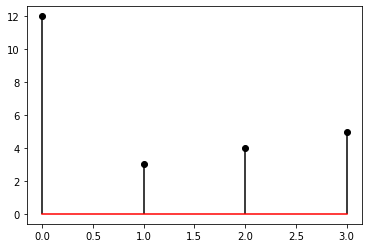

In [26]:
plt.stem([12,3,4,5], linefmt='k', markerfmt='ok', basefmt = 'r')

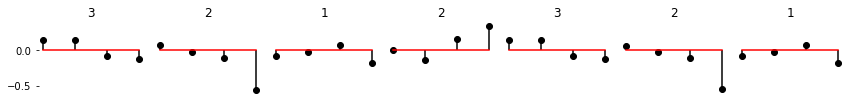

In [27]:
fig, ax = plt.subplots(1, 7, figsize=(12, 1.5), sharey=True)
for i in range(7):
    ax[i].stem(to_np(hiddens[i]).reshape((latent_size)), linefmt='k', markerfmt='ok', basefmt = 'r')
    ax[i].set_xticks([])
    ax[i].set_frame_on(False)
    if i != 0:
        ax[i].tick_params(left=False)
    ax[i].set_title(seq[i+2])
plt.tight_layout()
#plt.savefig(result_path + '/moving_bar_hidden.pdf')


In [28]:
hiddens

[tensor([[ 0.1534,  0.1414, -0.0844, -0.1201]]),
 tensor([[ 0.0702, -0.0193, -0.1109, -0.5568]]),
 tensor([[-0.0818, -0.0270,  0.0728, -0.1823]]),
 tensor([[ 0.0059, -0.1442,  0.1566,  0.3506]]),
 tensor([[ 0.1532,  0.1421, -0.0865, -0.1293]]),
 tensor([[ 0.0676, -0.0214, -0.1084, -0.5542]]),
 tensor([[-0.0817, -0.0276,  0.0749, -0.1731]]),
 tensor([[ 0.0084, -0.1421,  0.1541,  0.3480]]),
 tensor([[ 0.1530,  0.1428, -0.0886, -0.1384]])]

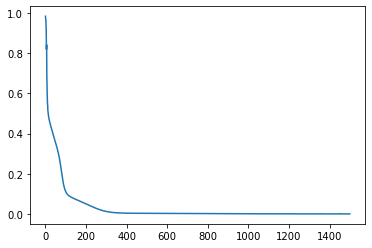

In [193]:
plt.figure()
plt.plot(train_losses)
#plt.savefig(result_path + f'/losses_moving_bar', dpi=150)


In [ ]:
fig, ax = plt.subplots(3, math.ceil(seq_len/3), figsize=(9, 1.5), sharey=True)
for i in range(seq_len):
    ax[i].stem(to_np(hiddens[i]).reshape((latent_size)), linefmt='k', markerfmt='ok', basefmt = 'r')
    ax[i].set_xticks([])
    ax[i].set_frame_on(False)
    if i != 0:
        ax[i].tick_params(left=False)
plt.tight_layout()
#plt.savefig(result_path + '/moving_bar_hidden.pdf')


In [ ]:
img3 = to_np(model(us[1, :], hiddens[1])[1]).reshape((h, w))
img5 = to_np(model(us[3, :], hiddens[3])[1]).reshape((h, w))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img3)
ax[0].axis('off')
ax[1].imshow(img5)
ax[1].axis('off')
#plt.savefig(result_path + '/forwarded.pdf')